### Задача

Есть приложене по доставке готовых продуктов

Проверить:
- виляние на заказы разрешения фотографии продукта (прямоугольные / квадратные)
- влияние на заказы кнопки заказа (новая / старая)

### Данные

In [8]:
import pandas as pd
import scipy.stats as ss
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
photo_df = pd.read_csv('photo.csv')
photo_df.head(3)

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30


In [10]:
photo_df.shape

(30000, 3)

- id - клиент
- group - разрешение
  - A - 16:9
  - B - квадрат
  - C - 12:4
- events - число заказов за период

In [44]:
photo_df.groupby('group').events.count()

group
A    10000
B    10000
C    10000
Name: events, dtype: int64

=> размеры групп равны

In [11]:
button_df = pd.read_csv('button.csv')
button_df.head(3)

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0


In [12]:
button_df.shape

(100000, 4)

- id - клиент
- group - вид кнопки
  - control - старая
  - test - новая
- segment - сегмент клиента (high/low)
- events - число заказов за период

In [45]:
button_df.groupby('group').events.count()

group
control    50000
test       50000
Name: events, dtype: int64

=> размеры групп равны

### Решение

#### Фотографии

Для сравнения выборок применим дисперсионный анализ

Требования для применения ANOVA:
- отсутствие выбросов
- гомогенность дисперсий
- независимость измерений
- желательно нормальность распределений

_Проверка на выбросы_

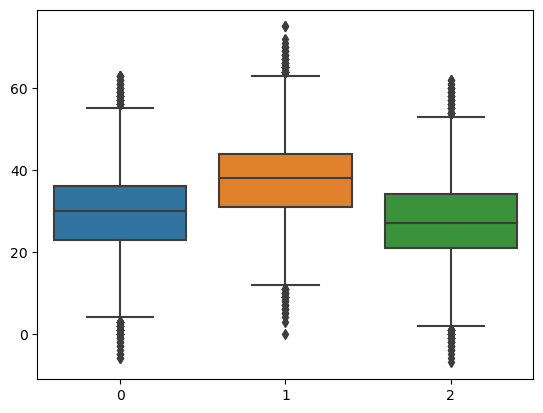

In [15]:
sns.boxplot([
    photo_df.query('group == "A"').events, 
    photo_df.query('group == "B"').events,
    photo_df.query('group == "C"').events
]);

Ощутимые выбросы отсутствуют

_Проверка на гомогенность дисперсий_

In [16]:
ss.levene(
    photo_df.query('group == "A"').events, 
    photo_df.query('group == "B"').events,
    photo_df.query('group == "C"').events
)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05 => гипотеза о разности дисперсий не подтвердилась

_Независимость измерений_ полагается за счёт дизайна эксперимента

_Нормальность распределений_

In [17]:
ss.normaltest(photo_df.query('group == "A"').events)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

In [18]:
ss.normaltest(photo_df.query('group == "B"').events)

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [19]:
ss.normaltest(photo_df.query('group == "C"').events)

NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)

=> распределения можно считать нормальными

Проверка по QQ-plot

In [37]:
# Настройка графиков
sns.set(font_scale=0.8,
        style='whitegrid',
        rc={"figure.figsize":(6, 4)})

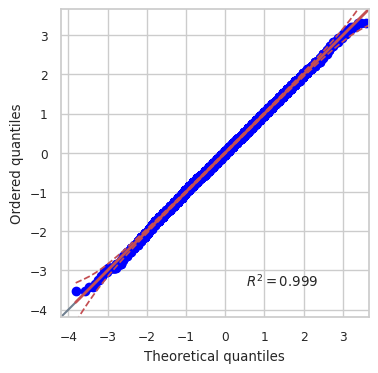

In [38]:
pg.qqplot(photo_df.query('group == "A"').events);

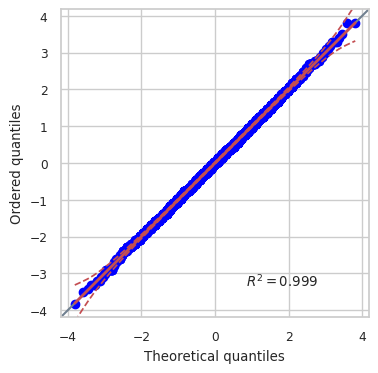

In [39]:
pg.qqplot(photo_df.query('group == "B"').events);

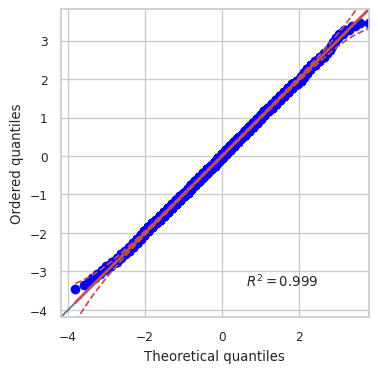

In [40]:
pg.qqplot(photo_df.query('group == "C"').events);

=> все требования для применения ANOVA соблюдены

_Применение ANOVA_

In [41]:
ss.f_oneway(
    photo_df.query('group == "A"').events, 
    photo_df.query('group == "B"').events,
    photo_df.query('group == "C"').events
)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

p-value < 0.05 => между группами обнаружены статзначимые различия

_Определение отличающихся групп_

In [42]:
pg.pairwise_tukey(data=photo_df, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


=> все группы имеют статзначимые отличия друг от друга

_Определение наилучшего формата картинки_

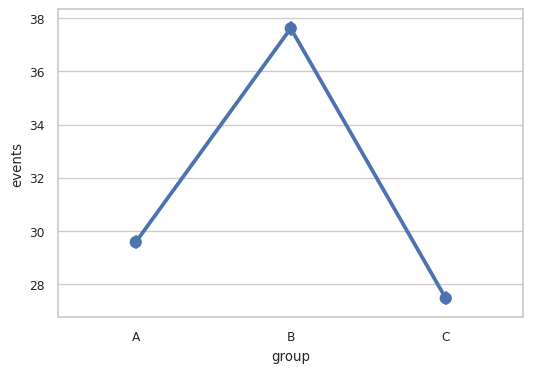

In [43]:
sns.pointplot(data=photo_df, x='group', y='events');

Наиболее активно заказы производила группа, которая взаимодействовала с квадратными фото

**Вывод:** наилучшее решение - квадратные фотографии

#### Кнопки

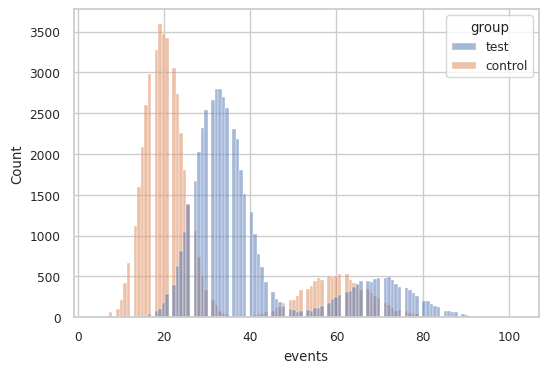

In [47]:
sns.histplot(data=button_df, x='events', hue='group');

Распределения для групп являются бимодальными (в силу 2х сегментов клиентов)

Для сравнения групп используем многофакторный дисперсионный анализ

_Выбросы_

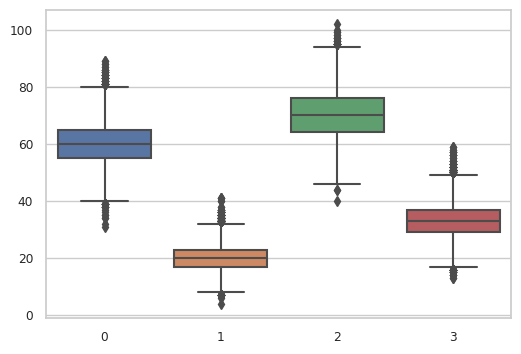

In [51]:
sns.boxplot([
    button_df.query('group == "control" and segment == "high"').events, 
    button_df.query('group == "control" and segment == "low"').events,
    button_df.query('group == "test" and segment == "high"').events, 
    button_df.query('group == "test" and segment == "low"').events
]);

_Дисперсии_

In [53]:
ss.levene(
    button_df.query('group == "control" and segment == "high"').events, 
    button_df.query('group == "test" and segment == "high"').events
)

LeveneResult(statistic=46.92819248194447, pvalue=7.577591733412336e-12)

In [54]:
ss.levene( 
    button_df.query('group == "control" and segment == "low"').events,
    button_df.query('group == "test" and segment == "low"').events
)

LeveneResult(statistic=1985.5666465281558, pvalue=0.0)

In [55]:
button_df.groupby(['group', 'segment']).events.std().to_frame()

events
group   segment          
control high     7.805347
        low      4.473576
test    high     8.403974
        low      5.720845

Имеются статзначимые различия в дисперсиях

_Нормальность_

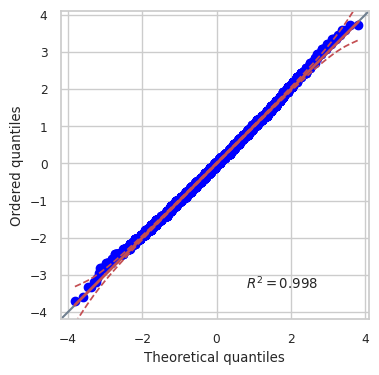

In [58]:
pg.qqplot(
    button_df.query('group == "control" and segment == "high"').events
);

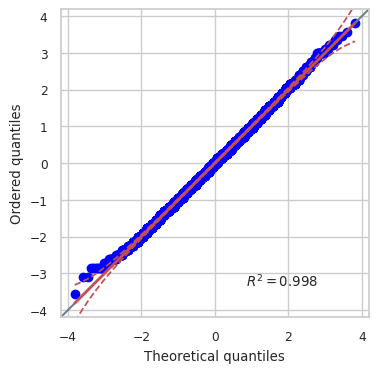

In [59]:
pg.qqplot(
    button_df.query('group == "test" and segment == "high"').events
);

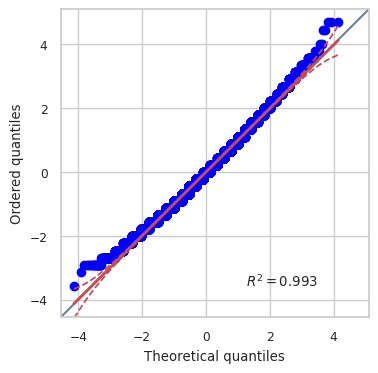

In [60]:
pg.qqplot(
    button_df.query('group == "control" and segment == "low"').events
);

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

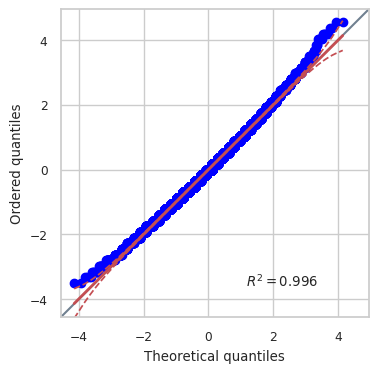

In [61]:
pg.qqplot(
    button_df.query('group == "test" and segment == "low"').events
)

_Многофакторный ANOVA_

In [62]:
pg.anova(
    data=button_df, 
    dv='events', 
    between=['group', 'segment']
)

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377485,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


=> оба фактора и их взаимодействие оказывают статзначимое влияние на интенсивность заказов

Детализация

In [64]:
button_df['comb_fac'] = button_df.group + ' / ' + button_df.segment

In [65]:
button_df.head(3)

,id,group,segment,events,comb_fac
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high


In [66]:
pg.pairwise_tukey(data=button_df, dv='events', between='comb_fac')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


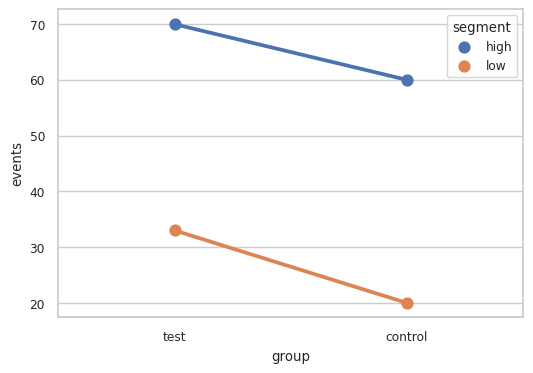

In [67]:
sns.pointplot(data=button_df, x='group', y='events', hue='segment');

**Вывод:** Новая кнопка стимулирует клиентов делать больше заказов

Inspired by: KCM7L5P